In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42


In [2]:
device


'cuda'

In [3]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

In [4]:
X, y = make_moons(n_samples=1000, random_state=42, noise=0.05)

In [5]:
import pandas as pd

features_df = pd.DataFrame(data=X)
target_df = pd.DataFrame(data=y)

In [6]:
#target_df.head()

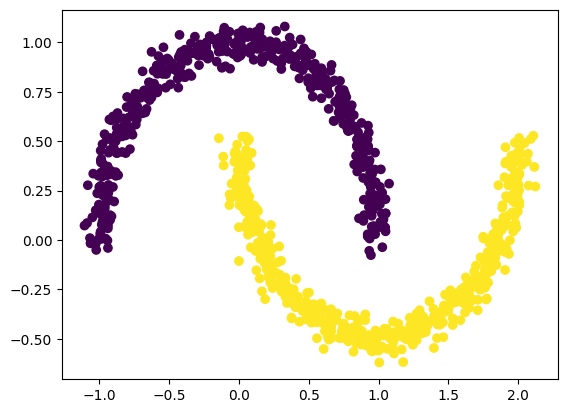

In [7]:
# visualize with the dataset
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y)
plt.show()

In [8]:
# Turn data into tensors of dtype float
tensor_X = torch.tensor(X, dtype=torch.float32)
tensor_y = torch.tensor(y, dtype=torch.float32)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tensor_X.to(device), tensor_y.to(device), test_size=0.2, random_state=42)

In [9]:
tensor_X.shape

torch.Size([1000, 2])

In [18]:
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, num_input_feats, num_output=1, num_hidden_neurons=10):
        super().__init__()

        self.first_hidden_layer = nn.Linear(in_features=num_input_feats, out_features=num_hidden_neurons)
        self.second_hidden_layer = nn.Linear(in_features=num_hidden_neurons, out_features=num_hidden_neurons)

        self.output_layer = nn.Linear(in_features=num_hidden_neurons, out_features=num_output)
        self.relu = nn.ReLU()

    def forward(self, x):
        ## Your code here ##
        return self.output_layer(self.relu(self.second_hidden_layer(self.relu(self.first_hidden_layer(x)))))

# Instantiate the model

model = MoonModelV0(2).to(device)

In [19]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [20]:
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [21]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy



In [22]:
## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [23]:
## TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1500

# Send data to the device


# Loop through the data
for epoch in range(epochs):
  ### Training


  # 1. Forward pass (logits output)
  y_logits = model(X_train).squeeze()

  # Turn logits into prediction probabilities
  y_prob = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()
  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model(X_test).squeeze()
    # Turn the test logits into prediction labels
    test_labels = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(y_test, test_labels)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69536, Accuracy: 0.37% | Test Loss: 0.69451, Test Accuracy: 0.50%
Epoch: 100 | Loss: 0.38731, Accuracy: 0.82% | Test Loss: 0.40230, Test Accuracy: 0.76%
Epoch: 200 | Loss: 0.23919, Accuracy: 0.88% | Test Loss: 0.23863, Test Accuracy: 0.90%
Epoch: 300 | Loss: 0.19506, Accuracy: 0.91% | Test Loss: 0.18747, Test Accuracy: 0.93%
Epoch: 400 | Loss: 0.15754, Accuracy: 0.94% | Test Loss: 0.14809, Test Accuracy: 0.94%
Epoch: 500 | Loss: 0.11404, Accuracy: 0.95% | Test Loss: 0.10442, Test Accuracy: 0.97%
Epoch: 600 | Loss: 0.07554, Accuracy: 0.98% | Test Loss: 0.06742, Test Accuracy: 0.99%
Epoch: 700 | Loss: 0.04933, Accuracy: 0.99% | Test Loss: 0.04286, Test Accuracy: 1.00%
Epoch: 800 | Loss: 0.03418, Accuracy: 1.00% | Test Loss: 0.02898, Test Accuracy: 1.00%
Epoch: 900 | Loss: 0.02519, Accuracy: 1.00% | Test Loss: 0.02096, Test Accuracy: 1.00%
Epoch: 1000 | Loss: 0.01953, Accuracy: 1.00% | Test Loss: 0.01597, Test Accuracy: 1.00%
Epoch: 1100 | Loss: 0.01574, Accuracy: 1.00%

In [24]:
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

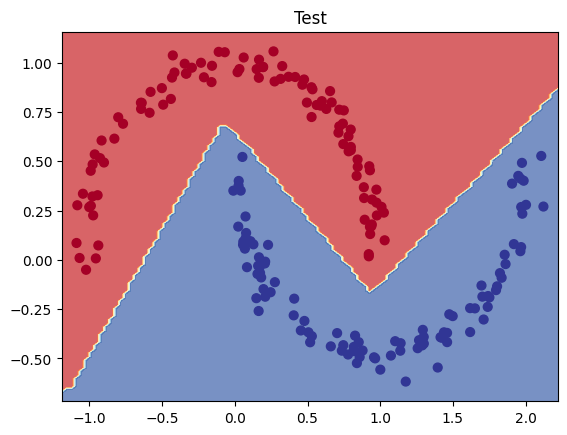

In [26]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model, X_test, y_test) # model_1 = no non-linearity
plt.title("Test")
plt.show()